<a href="https://colab.research.google.com/github/rituboora/Ritu-ipynb/blob/main/ritu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [5]:
import zipfile
import os

zip_path = "/content/archive.zip"  # Change to your uploaded file name
extract_path = "/content/dataset"

# Ensure the file exists before extracting
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("File not found. Make sure you uploaded the correct file.")


Dataset extracted successfully!


In [6]:
import os
print(os.listdir("/content/dataset"))


['1000_videos']


In [7]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
dataset_path = '/content/dataset'  # or wherever your extracted dataset is


In [17]:
import zipfile
import os
import shutil

# Extract to /content
zip_path = 'archive.zip'
extract_to = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Rename '1000 videos' to '1000_videos' to avoid space issues
original_folder = os.path.join(extract_to, "1000 videos")
renamed_folder = os.path.join(extract_to, "1000_videos")

if os.path.exists(original_folder):
    shutil.move(original_folder, renamed_folder)

# Check final structure
print("Extracted folders:", os.listdir(renamed_folder))


Extracted folders: ['train', 'validation', 'test']


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image sizes for different models
IMG_SIZE_RESNET = 224
IMG_SIZE_EFFICIENTNET = 380
BATCH_SIZE = 32

# Base path
base_path = "/content/1000_videos"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "validation")
test_dir = os.path.join(base_path, "test")

# Create ImageDataGenerators
train_val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ---------------------- RESNET ----------------------
train_generator_resnet = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE_RESNET, IMG_SIZE_RESNET),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator_resnet = train_val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE_RESNET, IMG_SIZE_RESNET),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator_resnet = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_RESNET, IMG_SIZE_RESNET),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ------------------ EFFICIENTNET ------------------
train_generator_efficient = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE_EFFICIENTNET, IMG_SIZE_EFFICIENTNET),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator_efficient = train_val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE_EFFICIENTNET, IMG_SIZE_EFFICIENTNET),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator_efficient = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_EFFICIENTNET, IMG_SIZE_EFFICIENTNET),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 11633 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Found 11633 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [26]:
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Function to build ResNet50 Model
def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(1, activation='sigmoid')(x)  # Binary classification output

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Function to build EfficientNetB7 Model
def build_efficientnet_model(input_shape=(380, 380, 3)):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [27]:
# Compile ResNet50 Model
resnet_model = build_resnet_model(input_shape=(IMG_SIZE_RESNET, IMG_SIZE_RESNET, 3))
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Compile EfficientNetB7 Model
efficientnet_model = build_efficientnet_model(input_shape=(IMG_SIZE_EFFICIENTNET, IMG_SIZE_EFFICIENTNET, 3))
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [28]:
# Train ResNet50 Model
history_resnet = resnet_model.fit(
    train_generator_resnet,
    validation_data=val_generator_resnet,
    epochs=10  # You can increase epochs as needed
)

# Train EfficientNetB7 Model
history_efficientnet = efficientnet_model.fit(
    train_generator_efficient,
    validation_data=val_generator_efficient,
    epochs=10  # You can increase epochs as needed
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


364/364 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.5001 - loss: 0.7821 - val_accuracy: 0.5233 - val_loss: 0.6915
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.5095 - loss: 0.7337 - val_accuracy: 0.5617 - val_loss: 0.6906
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.5024 - loss: 0.7132 - val_accuracy: 0.5063 - val_loss: 0.6905
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.4978 - loss: 0.7084 - val_accuracy: 0.5587 - val_loss: 0.6892
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.5132 - loss: 0.7009 - val_accuracy: 0.6446 - val_loss: 0.6881
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.5096 - loss: 0.6978 - val_accuracy: 0.6404 - val_loss: 0.6874
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.5154 - loss: 0.6952 - val_accuracy: 0.5746 - val_loss: 0.6870
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.5134 - loss: 0.6951 - val

In [33]:
# Final Epoch Index
last_epoch_resnet = len(history_resnet.history['accuracy']) - 1
last_epoch_eff = len(history_efficientnet.history['accuracy']) - 1

print("----- ResNet50 Training Performance -----")
print(f"Train Accuracy: {history_resnet.history['accuracy'][last_epoch_resnet]:.4f}")
print(f"Val Accuracy:   {history_resnet.history['val_accuracy'][last_epoch_resnet]:.4f}")
print(f"Train Loss:     {history_resnet.history['loss'][last_epoch_resnet]:.4f}")
print(f"Val Loss:       {history_resnet.history['val_loss'][last_epoch_resnet]:.4f}")

print("\n----- EfficientNetB7 Training Performance -----")
print(f"Train Accuracy: {history_efficientnet.history['accuracy'][last_epoch_eff]:.4f}")
print(f"Val Accuracy:   {history_efficientnet.history['val_accuracy'][last_epoch_eff]:.4f}")
print(f"Train Loss:     {history_efficientnet.history['loss'][last_epoch_eff]:.4f}")
print(f"Val Loss:       {history_efficientnet.history['val_loss'][last_epoch_eff]:.4f}")


----- ResNet50 Training Performance -----
Train Accuracy: 0.5263
Val Accuracy:   0.5575
Train Loss:     0.6916
Val Loss:       0.6855

----- EfficientNetB7 Training Performance -----
Train Accuracy: 0.5107
Val Accuracy:   0.5000
Train Loss:     0.6940
Val Loss:       0.6934


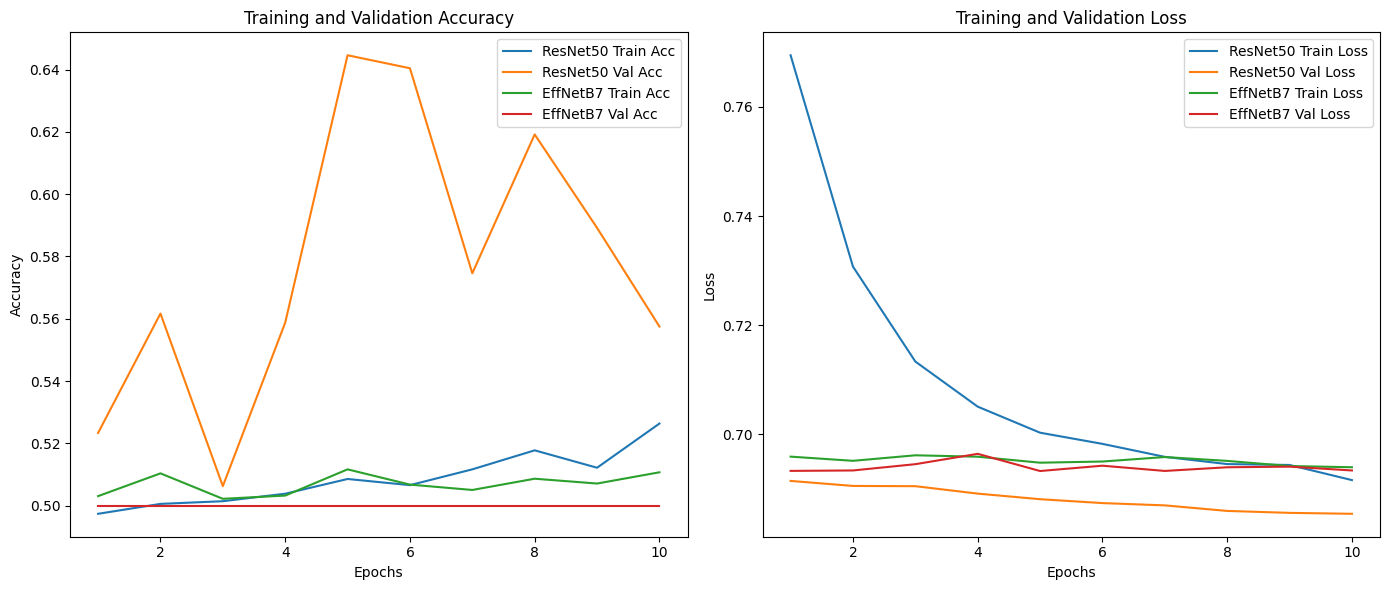

In [34]:
import matplotlib.pyplot as plt

def plot_training_metrics(history_resnet, history_efficientnet):
    epochs = range(1, len(history_resnet.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_resnet.history['accuracy'], label='ResNet50 Train Acc')
    plt.plot(epochs, history_resnet.history['val_accuracy'], label='ResNet50 Val Acc')
    plt.plot(epochs, history_efficientnet.history['accuracy'], label='EffNetB7 Train Acc')
    plt.plot(epochs, history_efficientnet.history['val_accuracy'], label='EffNetB7 Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_resnet.history['loss'], label='ResNet50 Train Loss')
    plt.plot(epochs, history_resnet.history['val_loss'], label='ResNet50 Val Loss')
    plt.plot(epochs, history_efficientnet.history['loss'], label='EffNetB7 Train Loss')
    plt.plot(epochs, history_efficientnet.history['val_loss'], label='EffNetB7 Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(history_resnet, history_efficientnet)


In [35]:
import pandas as pd

summary = {
    "Model": ["ResNet50", "EfficientNetB7"],
    "Train Accuracy": [
        history_resnet.history['accuracy'][-1],
        history_efficientnet.history['accuracy'][-1]
    ],
    "Validation Accuracy": [
        history_resnet.history['val_accuracy'][-1],
        history_efficientnet.history['val_accuracy'][-1]
    ],
    "Train Loss": [
        history_resnet.history['loss'][-1],
        history_efficientnet.history['loss'][-1]
    ],
    "Validation Loss": [
        history_resnet.history['val_loss'][-1],
        history_efficientnet.history['val_loss'][-1]
    ]
}

df = pd.DataFrame(summary)
print(df)


            Model  Train Accuracy  Validation Accuracy  Train Loss  \
0        ResNet50        0.526347               0.5575    0.691642   
1  EfficientNetB7        0.510702               0.5000    0.693998   

   Validation Loss  
0         0.685471  
1         0.693408  


In [29]:
# Evaluate ResNet50 on Test Data
print("Evaluating ResNet50 on Test Data:")
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_generator_resnet)
print(f"Test Accuracy for ResNet50: {resnet_test_acc:.4f}")
print(f"Test Loss for ResNet50: {resnet_test_loss:.4f}")

# Evaluate EfficientNetB7 on Test Data
print("Evaluating EfficientNetB7 on Test Data:")
eff_test_loss, eff_test_acc = efficientnet_model.evaluate(test_generator_efficient)
print(f"Test Accuracy for EfficientNetB7: {eff_test_acc:.4f}")
print(f"Test Loss for EfficientNetB7: {eff_test_loss:.4f}")


Evaluating ResNet50 on Test Data:
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8288 - loss: 0.6638
Test Accuracy for ResNet50: 0.5442
Test Loss for ResNet50: 0.6877
Evaluating EfficientNetB7 on Test Data:
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 752ms/step - accuracy: 0.8387 - loss: 0.6772
Test Accuracy for EfficientNetB7: 0.5000
Test Loss for EfficientNetB7: 0.6934


75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step

ResNet50 Classification Report:
              precision    recall  f1-score   support

        Real       0.52      0.95      0.68      1200
        Fake       0.75      0.13      0.23      1200

    accuracy                           0.54      2400
   macro avg       0.64      0.54      0.45      2400
weighted avg       0.64      0.54      0.45      2400



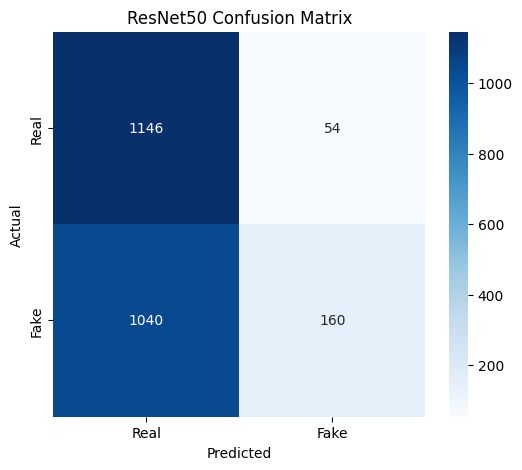

75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 754ms/step

EfficientNetB7 Classification Report:
              precision    recall  f1-score   support

        Real       0.50      1.00      0.67      1200
        Fake       0.00      0.00      0.00      1200

    accuracy                           0.50      2400
   macro avg       0.25      0.50      0.33      2400
weighted avg       0.25      0.50      0.33      2400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


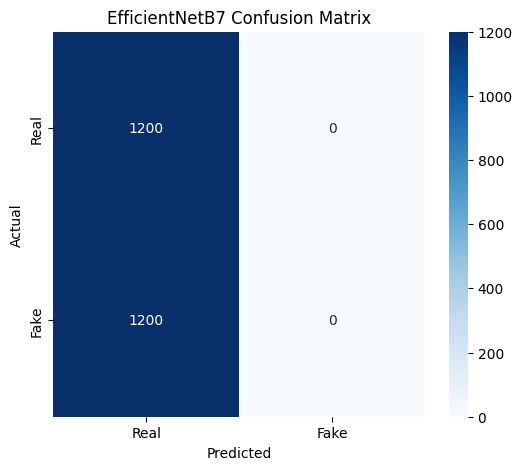

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, generator, model_name='Model'):
    # Get predictions
    y_pred = model.predict(generator)
    y_pred_classes = np.round(y_pred).astype(int).flatten()
    y_true = generator.classes  # True labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['Real', 'Fake']))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate ResNet50 on Test Data
evaluate_model(resnet_model, test_generator_resnet, 'ResNet50')

# Evaluate EfficientNetB7 on Test Data
evaluate_model(efficientnet_model, test_generator_efficient, 'EfficientNetB7')


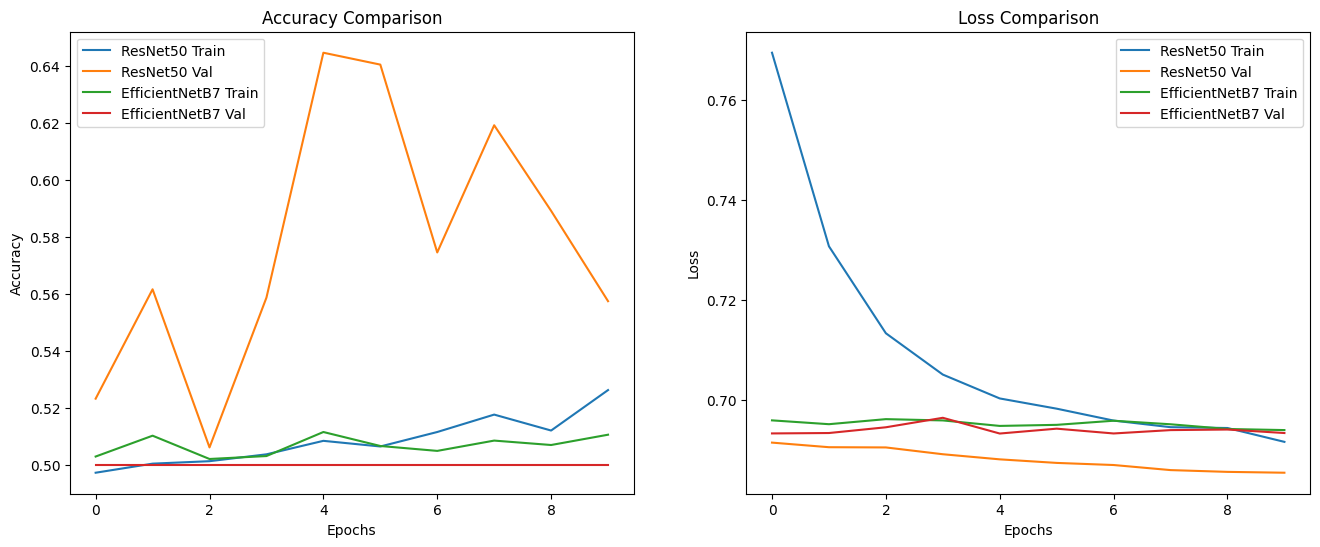

In [36]:
import matplotlib.pyplot as plt

def plot_comparison(history_resnet, history_efficientnet, label1='ResNet50', label2='EfficientNetB7'):
    epochs_resnet = range(len(history_resnet.history['accuracy']))
    epochs_efficientnet = range(len(history_efficientnet.history['accuracy']))

    plt.figure(figsize=(16, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_resnet, history_resnet.history['accuracy'], label=f'{label1} Train')
    plt.plot(epochs_resnet, history_resnet.history['val_accuracy'], label=f'{label1} Val')
    plt.plot(epochs_efficientnet, history_efficientnet.history['accuracy'], label=f'{label2} Train')
    plt.plot(epochs_efficientnet, history_efficientnet.history['val_accuracy'], label=f'{label2} Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_resnet, history_resnet.history['loss'], label=f'{label1} Train')
    plt.plot(epochs_resnet, history_resnet.history['val_loss'], label=f'{label1} Val')
    plt.plot(epochs_efficientnet, history_efficientnet.history['loss'], label=f'{label2} Train')
    plt.plot(epochs_efficientnet, history_efficientnet.history['val_loss'], label=f'{label2} Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot comparison between ResNet50 and EfficientNetB7
plot_comparison(history_resnet, history_efficientnet)


In [37]:
print("\nSummary Comparison of Models:")
print(f"ResNet50 - Test Accuracy: {resnet_test_acc:.4f}, Test Loss: {resnet_test_loss:.4f}")
print(f"EfficientNetB7 - Test Accuracy: {eff_test_acc:.4f}, Test Loss: {eff_test_loss:.4f}")



Summary Comparison of Models:
ResNet50 - Test Accuracy: 0.5442, Test Loss: 0.6877
EfficientNetB7 - Test Accuracy: 0.5000, Test Loss: 0.6934
